In [1]:
import re   
import os   
import pandas as pd     
import numpy as np    
import tensorflow as tf 
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split  

In [2]:
# 데이터 로드할 때 빠르게 로드
AUTOTUNE = tf.data.experimental.AUTOTUNE

ROOT_PATH =  os.path.join(os.getenv('HOME'), 'aiffel')

BATCH_SIZE = 16

IMAGE_SIZE = [150, 150]

EPOCHS = 20

nb_train_samples = 5217

nb_validation_samples = 17

폐렴 이미지의 수가 정상보다 3배 더 많이 있습니다. 불균형은 나중에 조절하겠습니다.

In [3]:
# 배치처리 작업을 효율적으로 처리하기 위함

train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print('정상 이미지 개수: {0} \n폐렴 이미지 개수: {1}'.format(COUNT_NORMAL, COUNT_PNEUMONIA))

정상 이미지 개수: 1341 
폐렴 이미지 개수: 3875


In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print('train 이미지 개수: {0} \nval 이미지 개수: {1}'.format(TRAIN_IMG_COUNT, VAL_IMG_COUNT))

train 이미지 개수: 5216 
val 이미지 개수: 16


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])

In [9]:
# 라벨을 리턴하는 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    if parts[-2] == "PNEUMONIA" :
        return 1
    else:
        return 0

# 이미지 형식을 재지정 해주는 함수
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

# 파일의 이미지와 라벨을 리턴하는 함수
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
# 이미지와 라벨이 잘 처리 되었는 지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (150, 150, 3)
Label:  1


In [12]:
# 테스트셋도 똑같이 처리
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = str(ROOT_PATH + '/chest_xray/train')
validation_data_dir = str(ROOT_PATH + '/chest_xray/val')
test_data_dir = str(ROOT_PATH + '/chest_xray/test')

In [14]:
img_width, img_height = 150, 150
epochs = 20
batch_size = 16

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K

In [36]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [39]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [40]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [41]:
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        class_weight=class_weight,)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 326 steps, validate for 1 steps
Epoch 1/20
326/326 [==============================] - 46s 140ms/step - loss: 0.4740 - accuracy: 0.7793 - precision: 0.9183 - recall: 0.7716 - val_loss: 1.5556 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 2/20
326/326 [==============================] - 45s 138ms/step - loss: 0.3150 - accuracy: 0.8717 - precision: 0.9567 - recall: 0.8666 - val_loss: 0.4615 - val_accuracy: 0.8125 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 3/20
326/326 [==============================] - 45s 139ms/step - loss: 0.2913 - accuracy: 0.8963 - precision: 0.9662 - recall: 0.8916 - val_loss: 1.0860 - val_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.8750
Epoch 4/20
326/326 [==============================] - 45s 138ms/step - loss: 0.2560 - accuracy: 0.9036 - precision: 0.9650 - recall: 0.9030 - val_loss: 0.5657 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000


## Summary

### 기본 모델

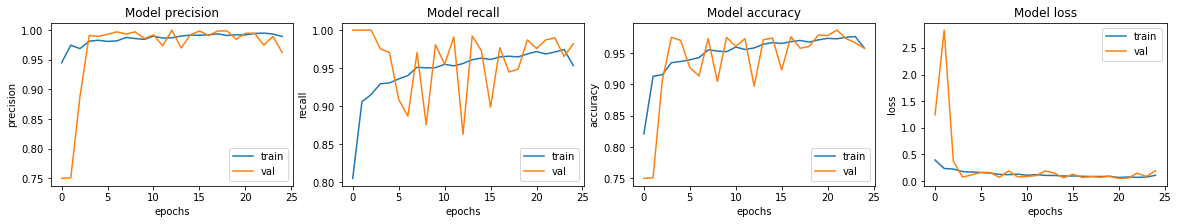

In [113]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [114]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 68ms/step - loss: 1.1597 - accuracy: 0.7756 - precision: 0.7376 - recall: 0.9949


### Augmention 적용 (flip 좌우, 상하)

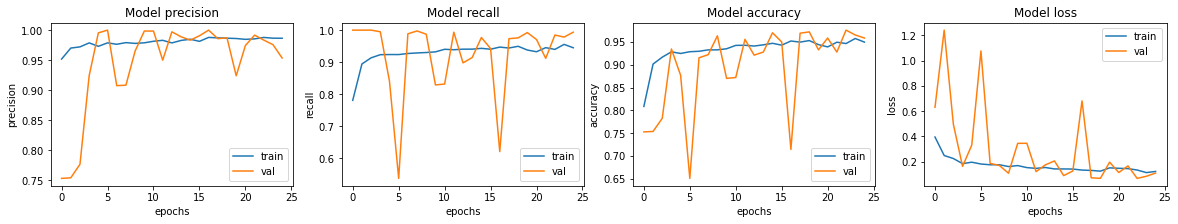

In [80]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [81]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 56ms/step - loss: 1.1345 - accuracy: 0.7035 - precision: 0.6783 - recall: 1.0000


### CustomSchedule 적용

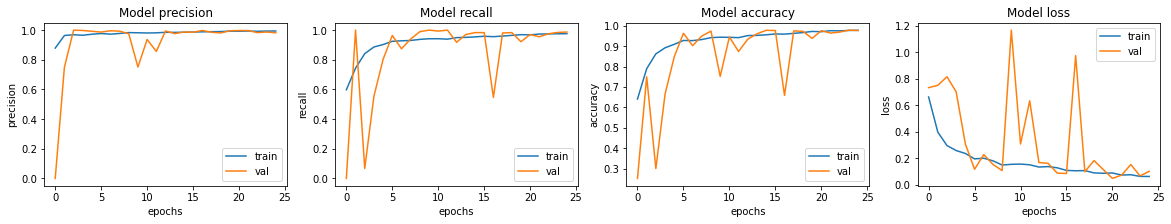

In [120]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [121]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 68ms/step - loss: 1.2560 - accuracy: 0.7660 - precision: 0.7293 - recall: 0.9949


### Augment 적용(flip 좌우만) && Adam 하이퍼 파라미터 조정

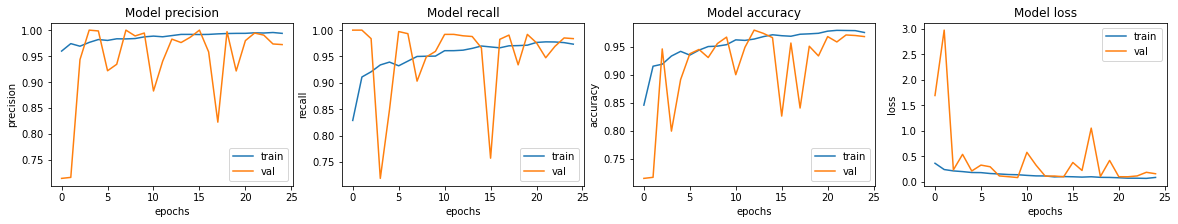

In [142]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [143]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 67ms/step - loss: 1.5135 - accuracy: 0.7564 - precision: 0.7204 - recall: 0.9974


### ImageDataGenerator 사용

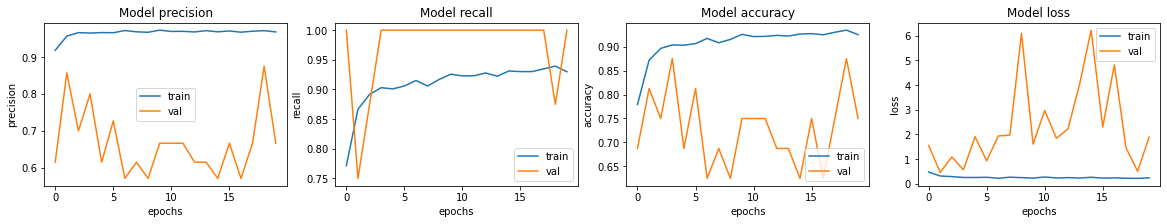

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [43]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 63ms/step - loss: 0.2902 - accuracy: 0.9135 - precision: 0.9019 - recall: 0.9667


### 최종 결과 요약

- 기본 모델 ----------------- accuracy: 0.7756 
- Augmention 적용 ---------- accuracy: 0.7035
- CustomSchedule 적용 ------ accuracy: 0.7660
- Adam 하이퍼 파라미터 조정 --- accuracy: 0.7564
- ImageDataGenerator 사용 -- accuracy: 0.9135 

최종적으로 ImageDataGenerator를 사용할 때 가장 잘나왔다.  
그런데 이때는 8:2로 split 하지 않고 train 데이터에 5216개의 데이터를 그대로 사용했다.  
학습에 사용되는 데이터가 더 많기 때문에 성능은 좋게 나왔으나, val data의 부족으로 overfitting이 생겨도 모른다는 단점이 있다.  
그리고 optimize로 Adam을 사용하지 않고 rmsprop를 사용한 것도 정확도에 영향을 준 것 같다.